# **PAIR TRADING STRATEGY BY GOPAL RAI**

# Libraries

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 38.3 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns; sns.set(style="whitegrid")
import statsmodels
import statsmodels.api as sm
import pandas_datareader as pdr
from datetime import datetime
from statsmodels.tsa.stattools import coint, adfuller

## **Normal And Lognormal Distribution for Stock Prices**


Stock Prices can be modeled using the Lognormal Distribution as long as we 
assume the growth factor to be be distributed normally.
<br>
This also alleviates the problem caused by normal distributions having a negative side as stock prices cannot have negative values.
<br>
Returns are usually assumed to be originating from Normal distribution so our modelling provides us with unique advantages.

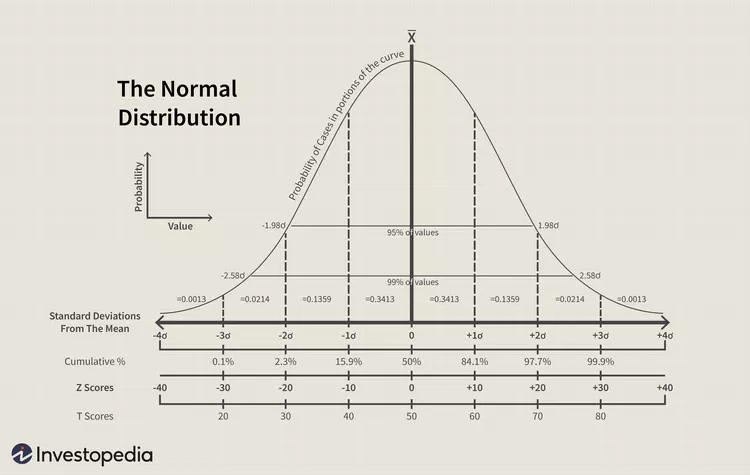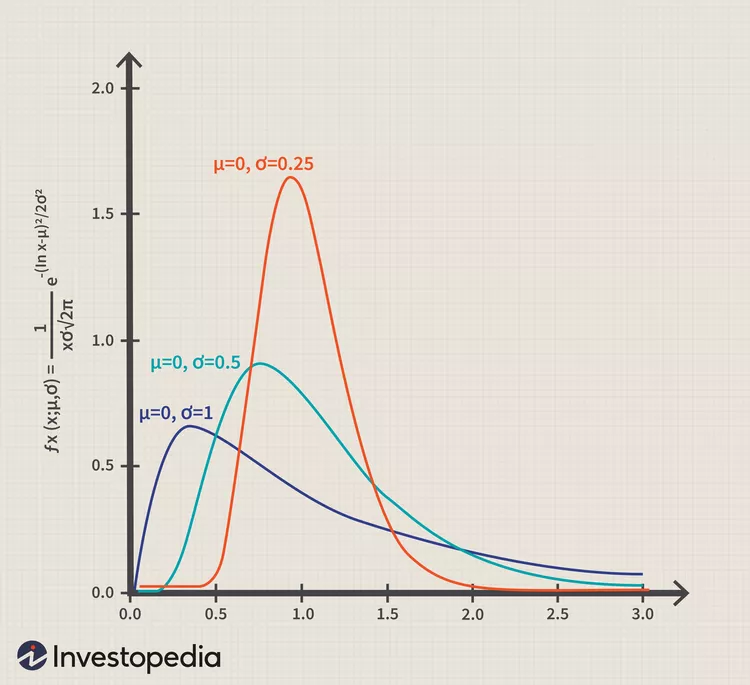

##**Random Walk Hypothesis**

According to the Random Walk Hypothesis, stock prices evolve according to a geometric random walk. That is,

\begin{align}
  S_t = S_{t-1}(1 + α)
\end{align}

where,
<br>
$S_t$ is the price of a stock at some time $t$ with $t$ being in a the form of some discrete time steps.
<br> 
$α$ is a random variable satisfying $α \sim N(μ, σ^2)$
<br>

This implication of this hypothesis is that stock prices cannot be predicted. To explain this random walk better, we have simulated a geometric random walk in the following section.

Here, error_term corresponds to $α$ which satisfies $α ∼ N(0.05, 0.1)$.
<br>
The walk is initialized with $S_0 = 1$

# **Simulating Geometric Random Walk**


In [ ]:
S = np.zeros(100)
S[0] = 1
error_term = np.random.randn(100)* 0.1 + 0.05
for i in range(1, 100):
  S[i] = S[i-1] * (1 + error_term[i])

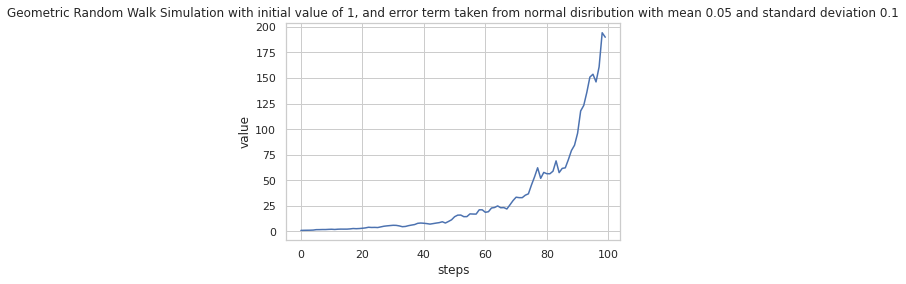

In [ ]:
timestamps = (np.zeros(100).astype(int))
for i in range(100):
  timestamps[i] = i
random_walk_graph = sns.lineplot(x=timestamps, y=S)
random_walk_graph.set(xlabel='steps', ylabel='value')
plt.title("Geometric Random Walk Simulation with initial value of 1, and error term taken from normal disribution with mean 0.05 and standard deviation 0.1")
plt.show()

##**Data importing and processing**

In [ ]:
symbols =  ['RELIANCE.NS','CIPLA.NS','WIPRO.NS','INDUSINDBK.NS','BHARTIARTL.NS','TCS.NS','TATASTEEL.NS','KOTAKBANK.NS','BAJFINANCE.NS','LT.NS','ICICIBANK.NS','BAJAJ-AUTO.NS','MARUTI.NS','TITAN.NS','BRITANNIA.NS','ULTRACEMCO.NS','TECHM.NS','M&M.NS']
asset_data =  yf.download(symbols, start="2017-03-20" ,end= "2022-12-20")['Adj Close']

asset_data.keys()

[*********************100%***********************]  18 of 18 completed


Index(['BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS',
       'CIPLA.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'KOTAKBANK.NS', 'LT.NS',
       'M&M.NS', 'MARUTI.NS', 'RELIANCE.NS', 'TATASTEEL.NS', 'TCS.NS',
       'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS'],
      dtype='object')

In [ ]:
asset_data.tail()

,BAJAJ-AUTO.NS,BAJFINANCE.NS,BHARTIARTL.NS,BRITANNIA.NS,CIPLA.NS,ICICIBANK.NS,INDUSINDBK.NS,KOTAKBANK.NS,LT.NS,M&M.NS,MARUTI.NS,RELIANCE.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,
2022-12-13,3636.750000,6620.100098,838.049988,4426.549805,1109.900024,932.950012,1234.949951,1868.500000,2172.899902,1283.349976,8620.700195,2625.000000,111.199997,3332.100098,1045.750000,2575.899902,7225.299805,397.750000
2022-12-14,3652.050049,6655.200195,829.200012,4409.700195,1112.699951,921.750000,1253.150024,1873.199951,2195.449951,1286.449951,8641.599609,2615.500000,113.050003,3365.350098,1065.099976,2591.100098,7197.549805,400.049988
2022-12-15,3619.300049,6625.399902,826.349976,4465.450195,1101.800049,908.799988,1239.599976,1863.199951,2177.550049,1286.949951,8584.150391,2578.350098,110.949997,3305.100098,1022.750000,2522.699951,7113.899902,395.200012
2022-12-16,3549.600098,6596.899902,822.750000,4444.700195,1089.400024,902.000000,1229.550049,1840.550049,2175.000000,1251.599976,8485.799805,2565.600098,111.050003,3240.250000,1020.799988,2482.850098,7014.100098,389.750000
2022-12-19,3627.100098,6688.000000,841.549988,4526.649902,1096.500000,906.950012,1223.400024,1860.599976,2185.649902,1289.900024,8620.000000,2601.449951,111.750000,3205.949951,1028.000000,2524.949951,7079.049805,389.299988


## **Cointegration**



### Cointegration is a statistical method used to test the correlation between two or more non-stationary time series in the long run or for a specified period.

## Function for finding cointegration of two time series

In [ ]:

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(n):
            s1 = data[keys[i]]
            s2 = data[keys[j]]
            result = coint(s1,s2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue
            if (pvalue < 0.05 and pvalue!=0):                #cutoff
                pairs.append((pvalue, (keys[i], keys[j])))
    return score_matrix, pvalue_matrix, pairs


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1605: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  

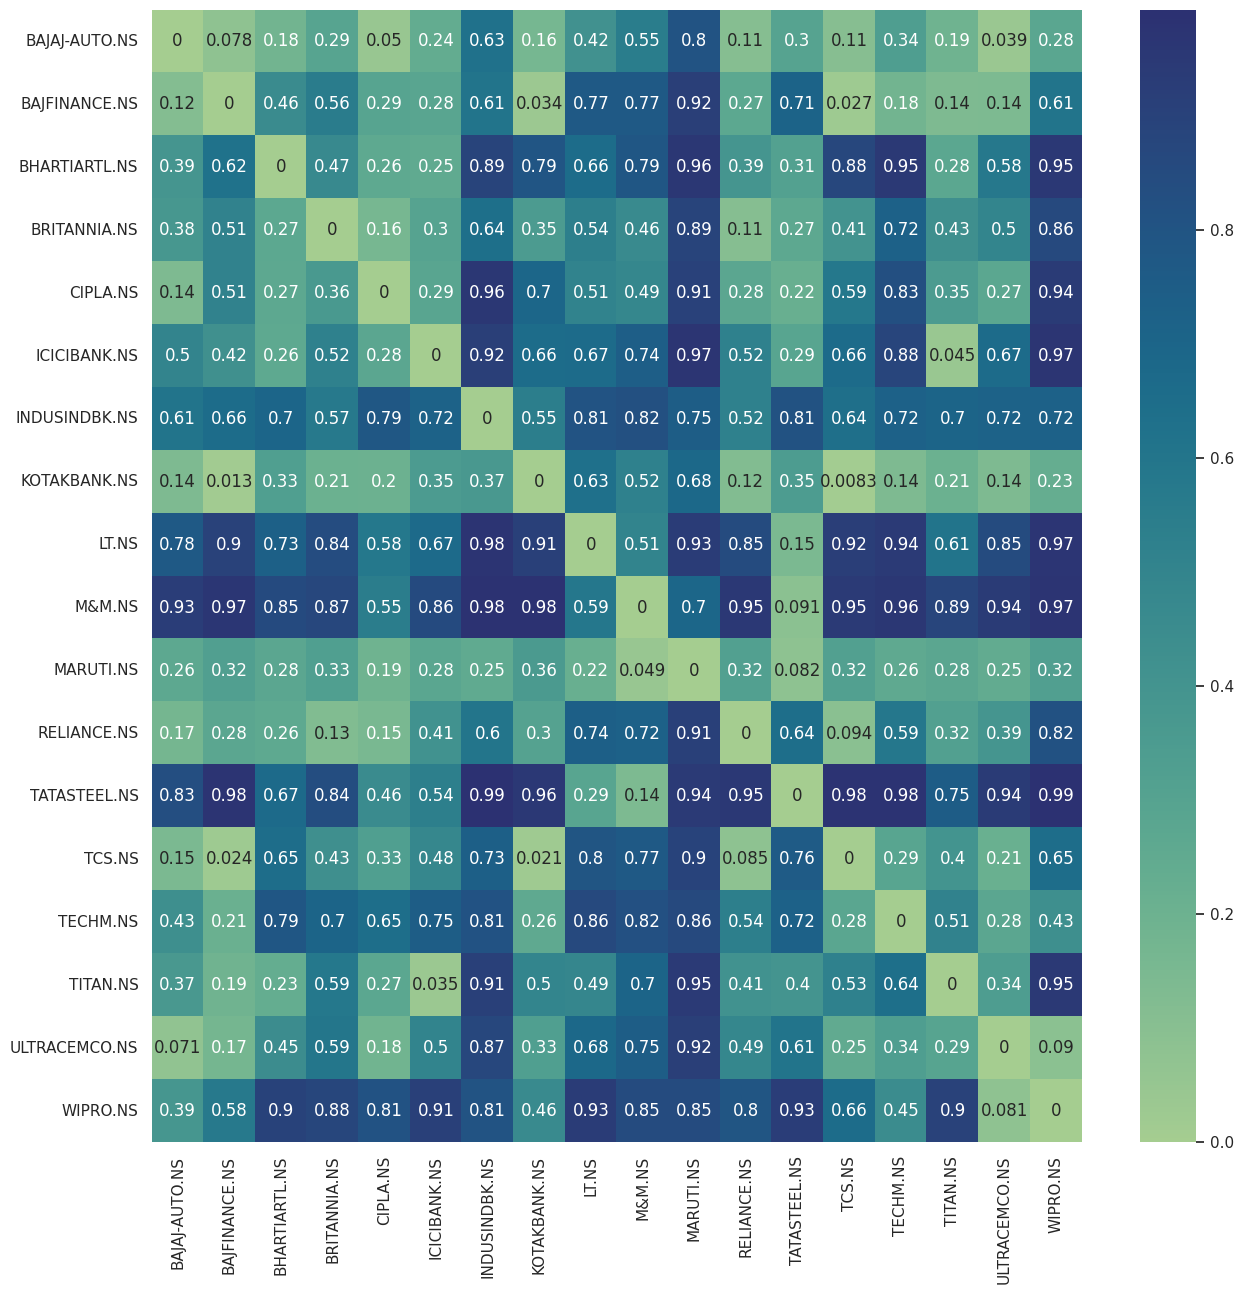

In [ ]:
scores, pvalues, pairs = find_cointegrated_pairs(asset_data)
from matplotlib.pyplot import figure
figure(figsize=(15, 15), dpi=100)
sns.heatmap(pvalues, xticklabels = asset_data.columns, yticklabels = asset_data.columns,
        cmap = 'crest',  annot = True)


Identifying the pairs of stocks having a co-integrating relationship, i.e, they have p-values less than the defined cutoff of 0.05

In [ ]:
pairs

[(0.03918791495573202, ('BAJAJ-AUTO.NS', 'ULTRACEMCO.NS')),
 (0.03422644296595413, ('BAJFINANCE.NS', 'KOTAKBANK.NS')),
 (0.026519063436089292, ('BAJFINANCE.NS', 'TCS.NS')),
 (0.045309409076467654, ('ICICIBANK.NS', 'TITAN.NS')),
 (0.012502207160025421, ('KOTAKBANK.NS', 'BAJFINANCE.NS')),
 (0.008250081104066755, ('KOTAKBANK.NS', 'TCS.NS')),
 (0.04914206796964147, ('MARUTI.NS', 'M&M.NS')),
 (0.024418551117233803, ('TCS.NS', 'BAJFINANCE.NS')),
 (0.020956168686894833, ('TCS.NS', 'KOTAKBANK.NS')),
 (0.03527187702451383, ('TITAN.NS', 'ICICIBANK.NS'))]

In [ ]:

min(pairs)

(0.008250081104066755, ('KOTAKBANK.NS', 'TCS.NS'))

[*********************100%***********************]  18 of 18 completed


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


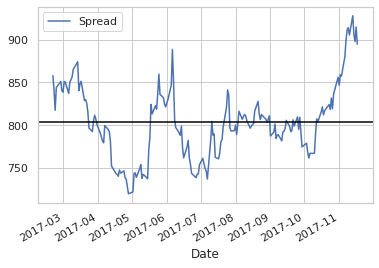

In [ ]:
symbols_pairs =  ['KOTAKBANK.NS', 'TCS.NS']
asset_pairs =  yf.download(symbols, start="2017-02-20" ,end= "2017-11-20")['Adj Close']

S1=asset_pairs['KOTAKBANK.NS']
S2=asset_pairs['TCS.NS']

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['KOTAKBANK.NS']
b = results.params['KOTAKBANK.NS']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

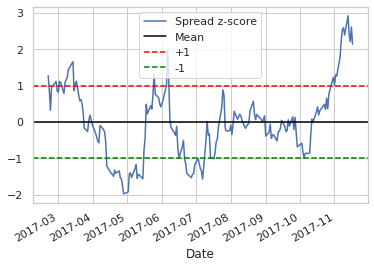

In [ ]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

**NORMALIZATION OF STOCK PRICES**

In [ ]:
start_date = '2017-01-01'
end_date = '2017-12-31'

tickers_list = ['KOTAKBANK.NS', 'TCS.NS']

data = pd.DataFrame(columns=tickers_list)

for ticker in tickers_list:
    data[ticker] = yf.download(ticker, 
                               start_date,
                               end_date)['Adj Close']
ratio= data['TCS.NS']/data['KOTAKBANK.NS']
    
data.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,KOTAKBANK.NS,TCS.NS
Date,,
2017-12-22,1007.883301,1208.757690
2017-12-26,1014.069946,1209.990967
2017-12-27,1011.874695,1196.495239
2017-12-28,1002.594666,1199.715210
2017-12-29,1008.032959,1233.624512


Plotting the stock price ratio for the two stocks

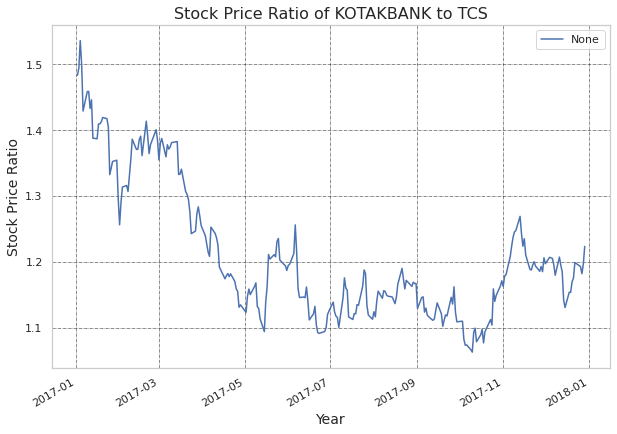

In [ ]:
ratio.plot(figsize=(10, 7))

plt.legend()

plt.title("Stock Price Ratio of KOTAKBANK to TCS", fontsize=16)

plt.ylabel('Stock Price Ratio', fontsize=14)
plt.xlabel('Year', fontsize=14)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. Z-scores also make it possible to adapt scores from data sets having a very different range of values to make scores that can be compared to one another more accurately.

Here, we have used Z-score to perform normalization on the stock price ratio

In [ ]:
z_scores = (ratio - ratio.mean())/ratio.std(ddof=0)

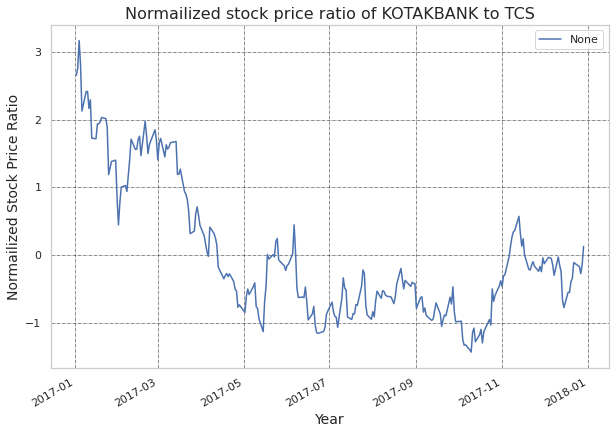

In [ ]:
z_scores.plot(figsize=(10, 7))

plt.legend()

plt.title("Normailized stock price ratio of KOTAKBANK to TCS", fontsize=16)

plt.ylabel('Normailized Stock Price Ratio', fontsize=14)
plt.xlabel('Year', fontsize=14)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [ ]:
start_date = '2017-01-01'
end_date = '2022-12-01'

tickers_list = ['KOTAKBANK.NS', 'TCS.NS']

data1 = pd.DataFrame(columns=tickers_list)

for ticker in tickers_list:
    data1[ticker] = yf.download(ticker, 
                               start_date,
                               end_date)['Adj Close']

    
data1.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,KOTAKBANK.NS,TCS.NS
Date,,
2022-11-24,1944.849976,3380.149902
2022-11-25,1928.400024,3389.649902
2022-11-28,1928.150024,3395.250000
2022-11-29,1925.550049,3397.350098
2022-11-30,1947.050049,3390.800049


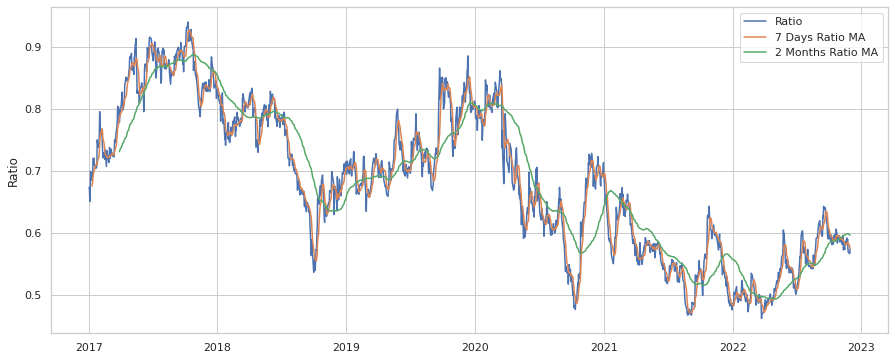

In [ ]:
stock1= "KOTAKBANK.NS"
stock2= "TCS.NS"
ratios = data1[stock1]/data1[stock2]
ratios_mavg_7d = ratios.rolling(window=7, center=False).mean()
ratios_mavg_2m = ratios.rolling(window=60, center=False).mean()
std_2m = ratios.rolling(window=60, center=False).std()
norm_score = (ratios_mavg_7d - ratios_mavg_2m)/std_2m
plt.figure(figsize=(15, 6))
plt.plot(ratios.index, ratios.values)
plt.plot(ratios_mavg_7d.index, ratios_mavg_7d.values)
plt.plot(ratios_mavg_2m.index, ratios_mavg_2m.values)
plt.legend(['Ratio', '7 Days Ratio MA', '2 Months Ratio MA'])

plt.ylabel('Ratio')
plt.show()

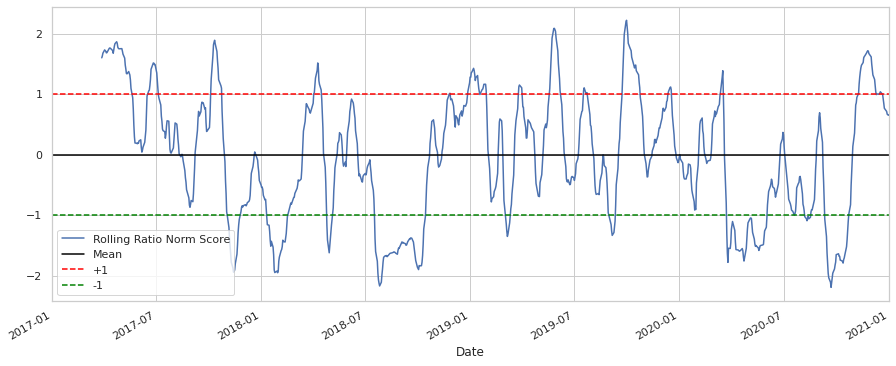

In [ ]:
plt.figure(figsize=(15,6))
norm_score.plot()
plt.xlim('2017', '2021')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio Norm Score', 'Mean', '+1', '-1'])
plt.show()

Creating a Strategy

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

Buy(1) whenever the norm_score is below -1, meaning we expect the ratio to increase.

Sell(-1) whenever the norm_score is above 1, meaning we expect the ratio to decrease.

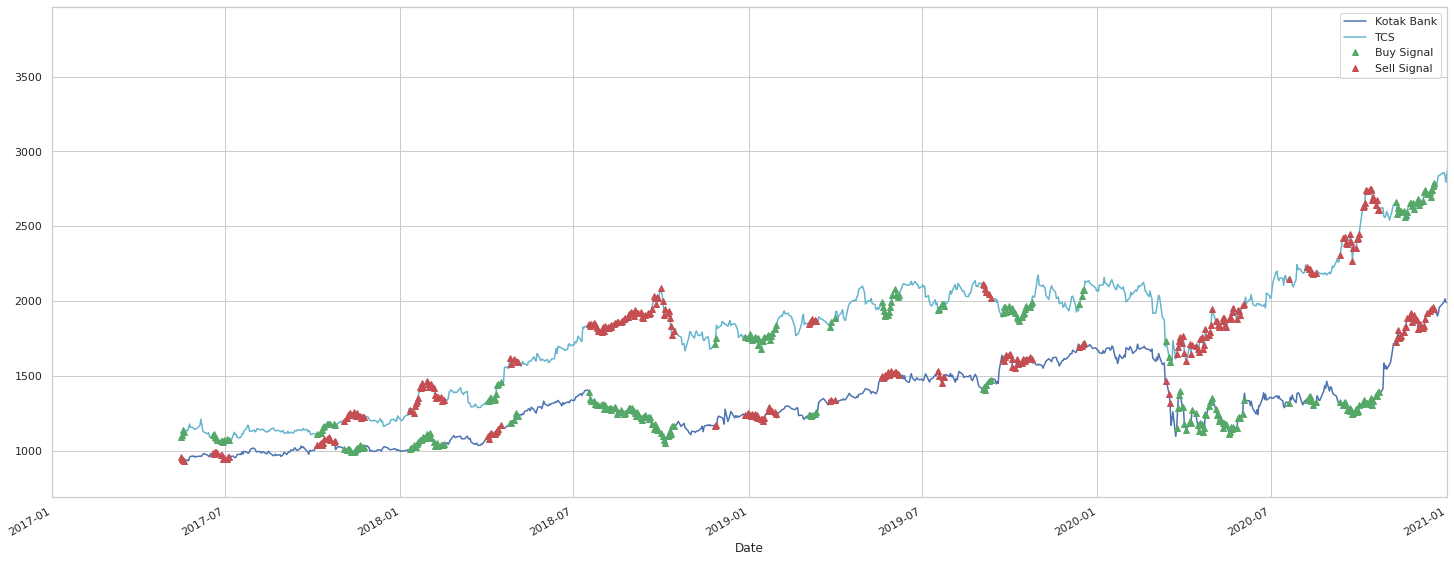

In [ ]:
plt.figure(figsize=(25,10))
stock1 = data1["KOTAKBANK.NS"]
stock2 = data1["TCS.NS"]

buy = ratios.copy()
sell = ratios.copy()
buy[norm_score>-1] = 0
sell[norm_score<1] = 0

stock1[90:].plot(color='b')
stock2[90:].plot(color='c')
buyR = 0*stock1.copy()
sellR = 0*stock1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = stock1[buy!=0]
sellR[buy!=0] = stock2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = stock2[sell!=0]
sellR[sell!=0] = stock1[sell!=0]

buyR[90:].plot(color='g', linestyle='None', marker='^')
sellR[90:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(stock1.min(), stock2.min()), max(stock1.max(), stock2.max())))
plt.xlim('2017', '2021')

plt.legend(['Kotak Bank','TCS', 'Buy Signal', 'Sell Signal'])
plt.show()

Trading Strategy

For the cointegration approach, we will use the moving averages to calculate the transactions to be done. First of all we calculate the moving average on window size of window1 (or short window) and window2 (long window) and the moving standard deviation for window size of window2 for the ratio(Y/X) of stocks.

Now, when moving_average_window1 > moving_average_window2 + c1 * standard_deviation_window2, we short the stock Y and go for long on stock X

We would square off when moving_average_window1 < moving_average_window2 - c2 * standard_deviation_window2

In [ ]:
def trade(stock1, stock2, window1=7, window2=60,MAX_AMOUNT=10000, MAX_TRANSACTION=5,c1=0.9,c2=0.8):
    #Computing the ratio over time
    ratios = stock1/stock2 
    # Compute rolling mean and rolling standard deviation
    ma1 = ratios.rolling(window=window1,center=False).mean()
    ma2 = ratios.rolling(window=window2,center=False).mean()
    std2 = ratios.rolling(window=window2,center=False).std()
    
    #initialising the money,number of transactions,number of stock1, stock2
    money=0
    stock1_count = 0
    stock2_count = 0
    trans = 0
    amount = MAX_AMOUNT/MAX_TRANSACTION
    for i in range(window2-1,len(ratios)):
        if ma1[i] < (ma2[i] - c1*std2[i]) and trans <= MAX_TRANSACTION :  
            trans +=1
            stock1_count += amount/stock1[i] 
            stock2_count -= amount/stock2[i]
        elif ma1[i] > (ma2[i]+c1*std2[i]) and trans <= MAX_TRANSACTION :
            trans +=1
            stock1_count -= amount/stock1[i] 
            stock2_count += amount/stock2[i]
        elif ma1[i] <= ma2[i]+c2*std2[i] and ma1[i] >= ma2[i]-c2*std2[i]:
            money += stock1[i] * stock1_count + stock2[i] * stock2_count
            stock1_count = 0
            stock2_count = 0
            trans = 0

    #Squaring off all transactions
    money += stock1[len(ratios)-1] * stock1_count + stock2[len(ratios)-1] * stock2_count

    return money

## **Demo Trading Results**

In [ ]:
coint_stocks = ['KOTAKBANK.NS','TCS.NS']
start = datetime(2021,1,1)
end = datetime(2022,11,1)
recent_data = yf.download(coint_stocks, start, end)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [ ]:
print("Net gain for Kotak Bank and TCS:",trade(recent_data['KOTAKBANK.NS'],recent_data['TCS.NS']))
print("Return:",trade(recent_data['KOTAKBANK.NS'],recent_data['TCS.NS'])/10000*100,"%\n")

Net gain for Kotak Bank and TCS: 4353.633389503381
Return: 43.53633389503381 %



Let's try using the same strategy for some random pairs of stocks

In [ ]:
random_stocks = ['CIPLA.NS','WIPRO.NS','TATACONSUM.NS','TCS.NS']
start = datetime(2021,1,1)
end = datetime(2022,11,1)
recent_data = yf.download(random_stocks, start, end)['Adj Close']
print("\nNet gain for Cipla and Wipro:",trade(recent_data['CIPLA.NS'],recent_data['WIPRO.NS']))
print("Return:",trade(recent_data['CIPLA.NS'],recent_data['WIPRO.NS'])/10000*100,"%\n")
print("Net gain for Tata Consumer and TCS:",trade(recent_data['TATACONSUM.NS'],recent_data['TCS.NS']))
print("Return:",trade(recent_data['TATACONSUM.NS'],recent_data['TCS.NS'])/10000*100,"%\n")

[*********************100%***********************]  4 of 4 completed

Net gain for Cipla and Wipro: -3683.3707275016677
Return: -36.83370727501668 %

Net gain for Tata Consumer and TCS: 1601.8901803645686
Return: 16.018901803645686 %



We can see that the strategy works well if the stocks are co-integrable otherwise it may not work well.